Install main Gymnasium library, Atari 2600 game familiy dependencies, and other Python libraries we'll be using for data manipulation & visualization

In [ ]:
!pip install gymnasium
!pip install "gymnasium[atari]"
!pip install "gymnasium[accept-rom-license]" #necessary for Atari envs

In [ ]:
!pip install numpy
!pip install seaborn
!pip install tqdm
%matplotlib inline

Import modules for code

In [ ]:
from collections import defaultdict #avoid key errors

import matplotlib.pyplot as plt #plots
from matplotlib.patches import Patch #shapes
import numpy as np
import seaborn as sns #further data visualization
from tqdm import tqdm #monitor progress for training

import gymnasium as gym

Create MsPacman environment, visualize the environment.
Our seed resets the RNG of the environment and produces a random state upon resetting

In [5]:
#from collections import defaultdict #avoid key errors

#import matplotlib.pyplot as plt #plots
#from matplotlib.patches import Patch #shapes
#import numpy as np
#import seaborn as sns #further data visualization
#from tqdm import tqdm #monitor progress for training

import gymnasium as gym

env = gym.make("ALE/MsPacman-v5")
observation, info = env.reset(seed=42)



#we are sampling 1000 actions from a possible selection of 9
#generally excluded actions have no effect in the specific game
#this env is built with 9 actions but can be tuned to 18 to match Atari systems

for _ in range(1000):
  action = env.action_space.sample() #remember, sampling from 1 - 9 here
  observation, reward, terminated, truncated, info = env.step(action)

  if terminated or truncated: #truncated, if the timer runs out
    observation, info = env.reset()

env.close()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/gymnasium/utils/passive_env_checker.py:364: UserWarning: WARN: No render fps was declared in the environment (env.metadata['render_fps'] is None or not defined), rendering may occur at inconsistent fps.
  logger.warn(


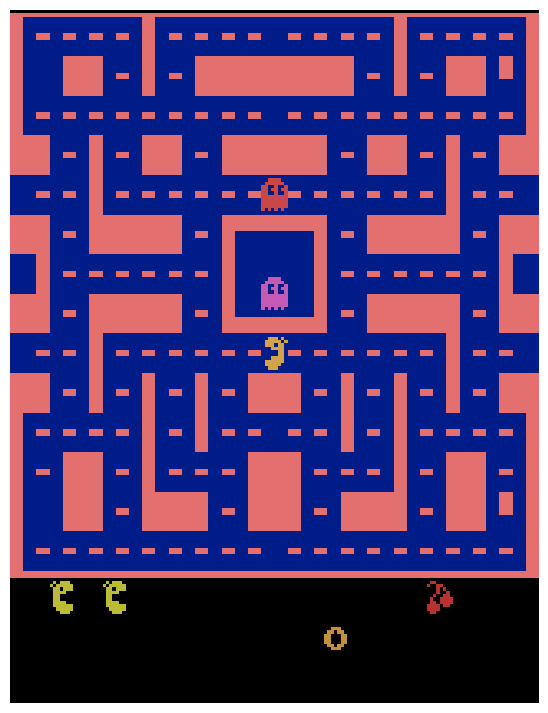

In [11]:
import gymnasium as gym
import matplotlib.pyplot as plt
from IPython import display #workaround to visualize env in jupyter notebook

env = gym.make("ALE/MsPacman-v5", render_mode='rgb_array')
env.reset()

plt.figure(figsize=(9, 9))
plt.imshow(env.render())
plt.axis('off')
plt.show()

env.close()

#simple visualization of the game state

Alright, we've set up our environment and created a basic loop to visualize different actions. Let's create a DQN Agent to train our model. We'll be implementing the algorithm here.

First step is to import the libraries we'll use. PyTorch is the framework I'm using to build the model.

In [ ]:
import random
import numpy as np
import torch
import torch.nn as nn #graphs
import torch.optim as optim #further optimization algorithms
import torch.nn.functional as F

Next step is to define the DQN class. This contains the components of the algorithm for later implementation in the DQN agent.

In [ ]:
class DQN(nn.Module):
  def __init__(self, input_shape, num_actions):
    super(DQN, self).__init__()
    #applies linear transformation to the input data
    #we define a neural network of 3 fully connected (fc) layers
    #input shape is the shape of our input state
    #num_actions is the variable representing total number of actions in env
    #in our case, num_actions is set to discrete 9 per this Atari game env
    self.fc1 = nn.Linear(input_shape, 64)
    self.fc2 = nn.Linear(64, 64)
    self.fc3 = nn.Linear(64, num_actions)

  def forward(self, x):
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)

    return x


Implement a replay buffer class, which will allow an agent to access their "memories" and train based on that data. The function below dictates the variables encapsulated in each experience pushed to the buffer. In this method those variables are self, state, action, reward, next_state, done.

In [ ]:
class ReplayBuffer():
  def __init__(self, capacity):
    self.capacity = capacity #buffer has a fixed capacity
    self.buffer = []
    self.position = 0

  def push(self, state, action, reward, next_state, done): #adds to buffer
    if len(self.buffer) < self.capacity:
      self.buffer.append(None) #overwrites the oldest experience if full
    self.buffer[self.position] = (state, action, reward, next_state, done)
    self.position = (self.position + 1) % self.capacity

  def sample(self, batch_size):
    #retrieves random batch of experiences from buffer
    batch = random.sample(self.buffer, batch_size)
    states, actions, rewards, next_states, dones = zip(*batch)
    return np.array(states), actions, rewards, np.array(next_states), dones

  def __len__(self):
    return len(self.buffer) #returns number of experiences in buffer

Implementing the actual algorithms in our DQNAgent class. This is my first time implementing these algorithms in code and as such could be further optimized with different policies.

In [ ]:
class DQNAgent():
  def __init__(self, env, replay_buffer, batch_size, gamma, epsilon_start, epsilon_end, epsilon_decay):
    #our initialization method sets up our networks, optimizer, and loss func
    self.env = env
    self.replay_buffer = replay_buffer
    self.batch_size = batch_size
    self.gamma = gamma
    self.epsilon = epsilon_start
    self.epsilon_end = epsilon_end
    self.epsilon_decay = epsilon_decay

    self.policy_net = DQN(env.observation_space.shape[0], env.action_space.n)
    self.target_net = DQN(env.observation_space.shape[0], env.action_space.n)
    self.target_net.load_state_dict(self.policy_net.state_dict())
    self.target_net.eval()

    self.optimizer.optim.Adam(self.policy_net.parameters())
    self.loss_fn = nn.SmoothL1Loss()

  def select_action(self, state):
    #selects action based on epsilon-greedy policy
    if random.random() < self.epsilon:
      return self.env.action_space.sample()
    else:
      with torch.no_grad():
        q_values = self.policy_net(torch.tensor(state, dtype=torch.float32))
        return q_values.argmax().item()

  def train(self, num_episodes):
    #runs training loop, we specify the number of episodes
    #for every episode, agent interacts with environment, collects experiences,
    #and updates the networks
    episode_rewards = []
    for episode in range(num_episodes):
      state = self.env.reset()
      done = False
      total_reward = 0

      while not done:
        action = self.select_action(state)
        next_state, reward, done, _ = self.env.step(action)
        self.replay_buffer.push(state, action, reward, next_state, done)
        state = next_state
        total_reward += reward

        if len(self.replay_buffer) >= self.batch_size:
          states, actions, rewards, next_states, dones = self.replay_buffer.sample(self.batch_size)
          self.update_network(states, actions, rewards, next_states, dones)

      self.epsilon = max(self.epsilon_end, self.epsilon * self.epsilon_decay)
      episode_rewards.append(total_reward)

      if episode % 100 == 0:
        print(f"Episode {episode}, Average Reward: {np.mean(episode_rewards[-100:])}")

  def update_network(self, states, actions, rewards, next_states, dones):
    #calculates loss, performs gradient descent, updates policy network
    #updates target network periodically
    states = torch.tensor(states, dtype=torch.float32)
    actions = torch.tensor(actions, dtype=torch.long).unsqueeze(1)
    rewards = torch.tensor(rewards, dtype=torch.float32)
    next_states = torch.tensor(next_states, dtype=torch.float32)
    dones = torch.tensor(dones, dtype=torch.float32)

    q_values = self.policy_net(states).gather(1, actions)
    next_q_values = self.target_net(next_states).max(1)[0].detach()
    expected_q_values = rewards + self.gamma * next_q_values * (1 - dones)

    loss = self.loss_fn(q_values, expected_q_values.unsqueeze(1))

    self.optimizer.zero_grad()
    loss.backward()
    self.optimizer.step()

    self.update_target_network()

  def update_target_network(self):
    self.target_net.load_state_dict(self.policy_net.state_dict())